# Imports

In [101]:
from typing import Optional
from typing import Union

In [102]:
from pathlib import Path
import requests
import gzip
import json
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

from tqdm import tqdm
tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt

# Global

In [130]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [103]:
DE_CORPUS_URL: str = 'https://object.pouta.csc.fi/OPUS-TED2020/v1/mono/de.txt.gz'
EN_CORPUS_URL: str = 'https://object.pouta.csc.fi/OPUS-TED2020/v1/mono/en.txt.gz'

In [104]:
DATA_PATH: Path = Path('data')
DE_EN_CORPUS_PATH: Path = Path.joinpath(DATA_PATH, 'de_en.json')
DE_EN_SENTIMENT_CORPUS_PATH: Path = Path.joinpath(DATA_PATH, 'de_en_sentiment.json')

# Utils

In [105]:
def download_file(
    url: str, 
    *,
    force: bool = False
) -> Path: 
    file_name: str = url.split('/')[-1]
    file_path: Path = Path.joinpath(DATA_PATH, file_name)
    
    if file_path.exists() and not force: 
        return file_path
    
    try:
        response: requests.Response = requests.get(url, stream=True)
        
        with file_path.open('wb') as file: 
            file.write(response.content)
            return file_path
    except Exception as e: 
        raise ValueError(f'An error occured: {e}')

In [106]:
def unzip_file(
    file_path_in: Path,
    *,
    file_path_out: Optional[Path] = None,
    remove_gz: bool = False
) -> Path:
    if file_path_in.suffix != '.gz':
        raise ValueError(f'File Path {file_path_in} is not a ".gz" file')

    if not file_path_out:
        file_path_out = file_path_in.with_suffix('')  # Removes the .gz suffix

    with gzip.open(file_path_in, 'rb') as file_in:
        with open(file_path_out, 'wb') as file_out:
            file_out.write(file_in.read())

    if remove_gz:
        file_path_in.unlink()

    return file_path_out

In [107]:
def hgf_sentiment_analyser(
    inputs: list[str],
    *,
    device: str,
    tokenizer: callable, # TODO correct typing
    model: callable # TODO correct typing,
) -> list[list[float]]:
    model.to(device)

    inputs = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        logits = model(**inputs).logits

    probabilities = torch.nn.functional.softmax(logits, dim=1)

    return probabilities

# Download Data

In [108]:
if not DATA_PATH.exists(): 
    DATA_PATH.mkdir()

In [109]:
DE_CORPUS_FILE_PATH: Path = download_file(DE_CORPUS_URL)
DE_CORPUS_FILE_PATH = unzip_file(DE_CORPUS_FILE_PATH)

In [110]:
EN_CORPUS_FILE_PATH: Path = download_file(EN_CORPUS_URL)
EN_CORPUS_FILE_PATH = unzip_file(EN_CORPUS_FILE_PATH)

# Make Parallel Corpus

In [111]:
de_corpus: list[str] = [s for s in DE_CORPUS_FILE_PATH.open('r')]
en_corpus: list[str] = [s for s in EN_CORPUS_FILE_PATH.open('r')]

In [112]:
parallel_corpus: list[tuple[str, str]] = list(zip(de_corpus, en_corpus))

In [113]:
with DE_EN_CORPUS_PATH.open('w') as de_en_file: 
    de_en_file.write(json.dumps(parallel_corpus, indent=4))

# Data

In [114]:
DE_EN_DF: pd.DataFrame = pd.read_json(DE_EN_CORPUS_PATH)
DE_EN_DF.columns = ['DE', 'EN']

In [115]:
DE_EN_DF.head()

,DE,EN
0,In der Mitte des 16ten Jahrhunderts waren die ...,"In the mid-16th century, Italians were captiva..."
1,Diese Gabe kam jedoch mit einem schweren Preis.\n,"However, this gift came at a high price.\n"
2,"Um ihren Stimmbruch zu verhindern, wurden die ...","To prevent their voices from breaking, these s..."
3,"Bekannt als ""Castrati"", waren ihre hellen, him...","Known as castrati, their light, angelic voices..."
4,Obwohl das Hemmen des Stimmwachstums eine ungl...,Though stunting vocal growth can produce an ex...


In [116]:
DE_EN_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339766 entries, 0 to 339765
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   DE      339766 non-null  object
 1   EN      339766 non-null  object
dtypes: object(2)
memory usage: 5.2+ MB


In [117]:
# TEST
# DE_EN_DF = DE_EN_DF.sample(5)

# Exploratory Data Analysis

# Sentiment Analysis (Inference)

https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment

In [118]:
TOKENIZER = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment") # TODO correct typing
MODEL = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment") # TODO correct typing

In [119]:
tqdm.pandas(desc='Progress German Texts:')
de_sentiments_df: pd.DataFrame = DE_EN_DF['DE'].progress_apply(lambda text: hgf_sentiment_analyser(list(text), tokenizer=TOKENIZER, model=MODEL).tolist()[0]).apply(pd.Series)

Progress German Texts:: 100%|██████████| 5/5 [00:00<00:00,  5.97it/s]


In [120]:
tqdm.pandas(desc='Progress English Texts:')
en_sentiments_df: pd.DataFrame = DE_EN_DF['EN'].progress_apply(lambda text: hgf_sentiment_analyser(list(text), tokenizer=TOKENIZER, model=MODEL).tolist()[0]).apply(pd.Series)

Progress English Texts:: 100%|██████████| 5/5 [00:00<00:00, 11.69it/s]


In [121]:
de_sentiments_df.columns = ['DE_-2', 'DE_-1', 'DE_0', 'DE_1', 'DE_2']
en_sentiments_df.columns = ['EN_-2', 'EN_-1', 'EN_0', 'EN_1', 'EN_2']

In [122]:
DE_EN_DF = pd.concat([DE_EN_DF, de_sentiments_df, en_sentiments_df], axis=1)

In [123]:
DE_EN_DF['DE_sentiment'] = DE_EN_DF.filter(like='DE_').idxmax(axis=1)
DE_EN_DF['DE_sentiment'] = DE_EN_DF['DE_sentiment'].apply(lambda x: int(x.split('_')[-1]))

In [124]:
DE_EN_DF['EN_sentiment'] = DE_EN_DF.filter(like='EN_').idxmax(axis=1)
DE_EN_DF['EN_sentiment'] = DE_EN_DF['EN_sentiment'].apply(lambda x: int(x.split('_')[-1]))

In [125]:
DE_EN_DF.head()

,DE,EN,DE_-2,DE_-1,DE_0,DE_1,DE_2,EN_-2,EN_-1,EN_0,EN_1,EN_2,DE_sentiment,EN_sentiment
234558,Bedenken Sie: Kanada ist heute eines der offen...,OK.\n,0.122102,0.162249,0.291120,0.240129,0.184400,0.211140,0.153613,0.275090,0.175653,0.184504,0,0
87962,In seinem Vortrag erklärt er Physik als die Ge...,They make up about one percent of all cancers.\n,0.132146,0.136207,0.237621,0.245278,0.248748,0.138471,0.129671,0.187644,0.224216,0.319997,2,2
17206,"Sie sind wirklich vorsichtig bei dem, was sie ...",A loud noise will get your fight-or-flight res...,0.107244,0.098929,0.200503,0.301680,0.291644,0.086779,0.074684,0.228180,0.318707,0.291649,1,1
178390,"Das ist ein Stück Geschichte, verpackt in Math...","You see, this is a human brain model, OK?\n",0.160353,0.160295,0.249987,0.205827,0.223538,0.090636,0.102885,0.180398,0.295041,0.331039,0,2
331259,"Die Menschen beherrschen den Planeten, weil si...",So I actually was interested enough in this to...,0.160353,0.160295,0.249987,0.205827,0.223538,0.107244,0.098929,0.200503,0.301680,0.291644,0,1


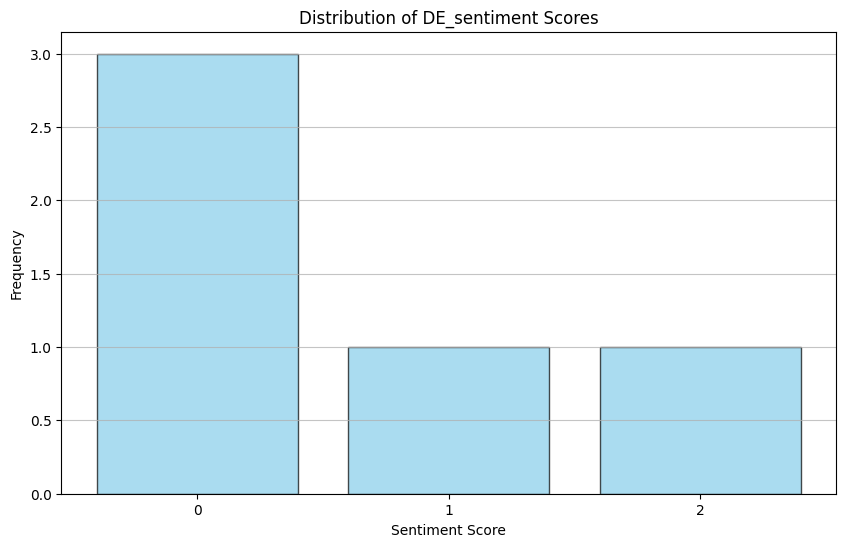

In [128]:
sentiment_counts = DE_EN_DF["DE_sentiment"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color='skyblue', edgecolor='k', alpha=0.7)
plt.title('Distribution of DE_sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xticks(sentiment_counts.index)  
plt.grid(axis='y', alpha=0.75)

# Store to Disk

In [129]:
DE_EN_DF.to_json(DE_EN_SENTIMENT_CORPUS_PATH, orient='records', lines=True)